### Alteration mapping

In this notebook we develop some hyperspectral proxies for alteration and apply this to our dataset

In [1]:
import hklearn 
from hklearn import Stack
import joblib
import matplotlib.pyplot as plt
import numpy as np
from hklearn.transforms import LogRatioScaler
import hylite
import pandas as pd
from hycore import loadShed
from sklearn.metrics import r2_score
from hylite.analyse import band_ratio, minimum_wavelength
from hylite.correct import get_hull_corrected
from hylite import io
import os
from hylite.filter import group_tiles
from tqdm import tqdm

hylite.band_select_threshold = 50.

In [2]:
#setup figure styles
import matplotlib as mpl
plt.style.use(['default'])
mpl.rcParams['font.size'] = 20
mpl.rcParams['figure.titleweight'] = 'normal'
mpl.rcParams['savefig.dpi'] = 350
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = True
mpl.rcParams['axes.spines.top'] = True
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2
dipcmap = plt.get_cmap("RdYlGn_r")

In [3]:
# load mechanical data
df = pd.read_excel('SWIR_MWIR_LWIR_SpecLib_v3.xlsx')
S = loadShed('VolcanoSamples.shed')

In [4]:
# get target variables
target_names = ['density','porosity','UCS2_MPa','E_GPa']
y = np.array(df[target_names])
ids = np.array(df['ID'])

In [5]:
swir = io.load('./swir.lib')
mwir = io.load('./mwir.lib')
lwir = io.load('./lwir.lib')

volcanoes = np.load('./volcanoes.npy')
sampleIDs = np.load('./sampleIDs.npy')
mech_avg = np.load( './mechAvg.npy')

### Compute average spectral proxies

In [6]:
indices = {}

#indices['Qtz'] = np.clip( band_ratio(lwir, [8216., 9200.], [8620., 8620.]).X()[:,0], 0.8, np.inf )
indices['Qtz'] = np.clip( band_ratio(lwir, 9240., 9600.).X()[:,0], 0.8, np.inf )
#indices['Qtz2'] = minimum_wavelength( mwir, 4600., 4800., method='gauss', minima=True, trend='hull', vb=False )[0].data[:,0,0]
indices['Qtz2'] = minimum_wavelength( mwir, 4400., 4600., method='gauss', minima=True, trend='hull', vb=False )[0].data[:,0,0]

indices['H2O'] = minimum_wavelength( swir, 1800., 2120., method='gauss', minima=True, trend='hull', vb=False )[0].data[:,0,0]
indices['OH'] = minimum_wavelength( swir, 1350., 1600., method='gauss', minima=True, trend='hull', vb=False )[0].data[:,0,0]
indices['SO4'] = minimum_wavelength( swir, 1700., 1800., method='gauss', minima=True, trend='hull', vb=False )[0].data[:,0,0]
indices['AlOH'] = minimum_wavelength( swir, 2150., 2240., method='gauss', minima=True, trend='hull', vb=False )[0].data[:,0,0]
indices['FeOH'] = minimum_wavelength( swir, 2230., 2280., method='gauss', minima=True, trend='hull', vb=False )[0].data[:,0,0]
indices['MgOH'] = minimum_wavelength( swir, 2280., 2330., method='gauss', minima=True, trend='hull', vb=False )[0].data[:,0,0]
indices['Kaol'] = minimum_wavelength( swir, 2100., 2200., method='gauss', minima=True, trend='hull', vb=False )[0].data[:,0,0]
#indices['Qtz'] = minimum_wavelength( lwir, 7640., 8630., method='gauss', minima=False, trend='hull', vb=False )[0].data[:,0,0]
indices['fmi'] = minimum_wavelength( lwir, 7640., 10620., method='poly', minima=False, trend='hull', vb=False )[0].data[:,0,1] # N.B FMI is the position
indices['fmi'] = 1 - ( (indices['fmi'] - 7640) / (10620-7640)) # convert to range between 0 [mafic] and 1 [felsic]

indices['hydration'] = 0.5*(indices['H2O'] + indices['OH']) # average the OH- and H-O-H components to get hydration index

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Plot some example spectra

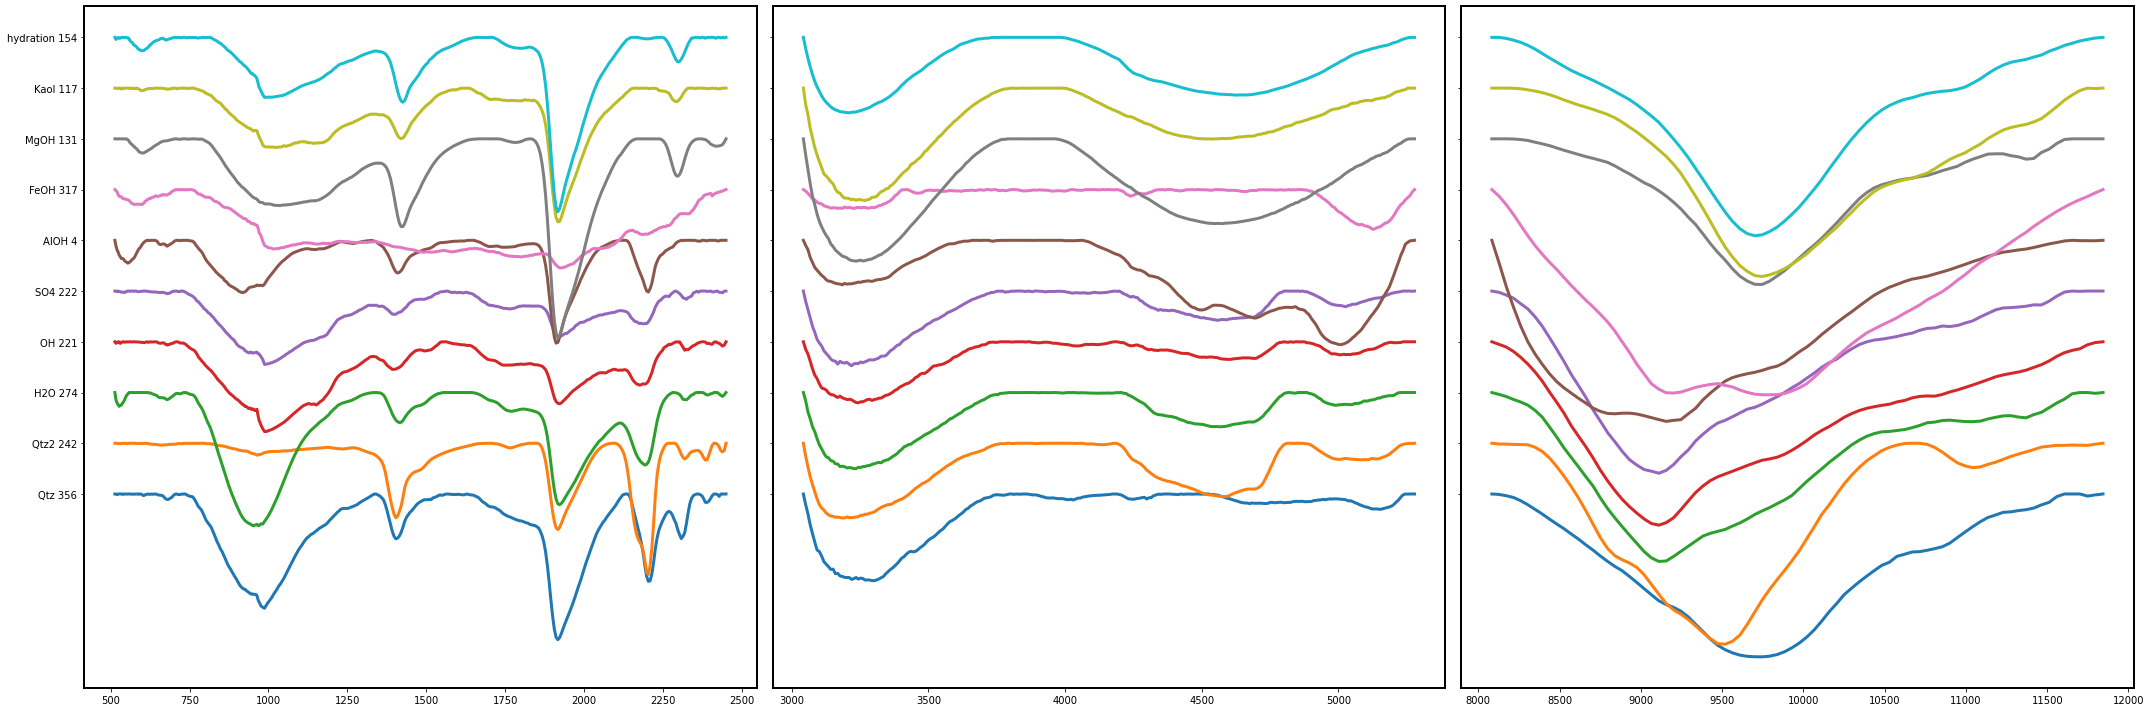

In [7]:
from hylite.correct import get_hull_corrected

fig,ax = plt.subplots(1,3, figsize=(30,10), sharey=True)
offset = 0
ticks = []
names = []

#swir_hc = get_hull_corrected(swir)
features = {#'Qtz':(8200., 9300., 8625),
            'Qtz':(9240., 9600., 9240),
            'Qtz2':(8200., 9300., 8625),
            'H2O':(1800., 2120., 1900.),
            'OH':(1350., 1600., 1440.),
            'SO4':(1700., 1800.,1750.),
            'AlOH':(2150., 2240.,2200.),
            'MgOH':(2280., 2330., 2300.),
            'FeOH':(2230., 2280.,2245),
            'Kaol':(2100., 2200.,2160.) }
for k in indices.keys():
    if (k == 'fmi') or (k=='mech'):
        continue
    ticks.append(offset)
    mask = indices[k] < np.nanpercentile( indices[k], 50 )
    ix = np.nanargmax( indices[k][mask] )
    n = swir.get_sample_names()[mask][ix]
    ax[0].plot( swir.get_wavelengths()[40:-10], get_hull_corrected( swir.data[ix,0,40:-10],)+offset - 1, label=n, lw=3 )
    ax[1].plot( mwir.get_wavelengths()[40:], get_hull_corrected( mwir.data[ix,0,40:])+offset - 1, label=n, lw=3 )
    p = ax[2].plot( lwir.get_wavelengths()[10:-10], get_hull_corrected( lwir.data[ix,0,10:-10], hull='lower' ) + offset - 1, label=n, lw=3 )
    c = p[0].get_color()
    offset += 0.2
    names.append(k + (" %d"%ix))
    
#ax[0].legend(ncol=3)
ax[0].set_yticks(ticks)
ax[0].set_yticklabels(names)
fig.tight_layout()
fig.show()

Create alteration biplot

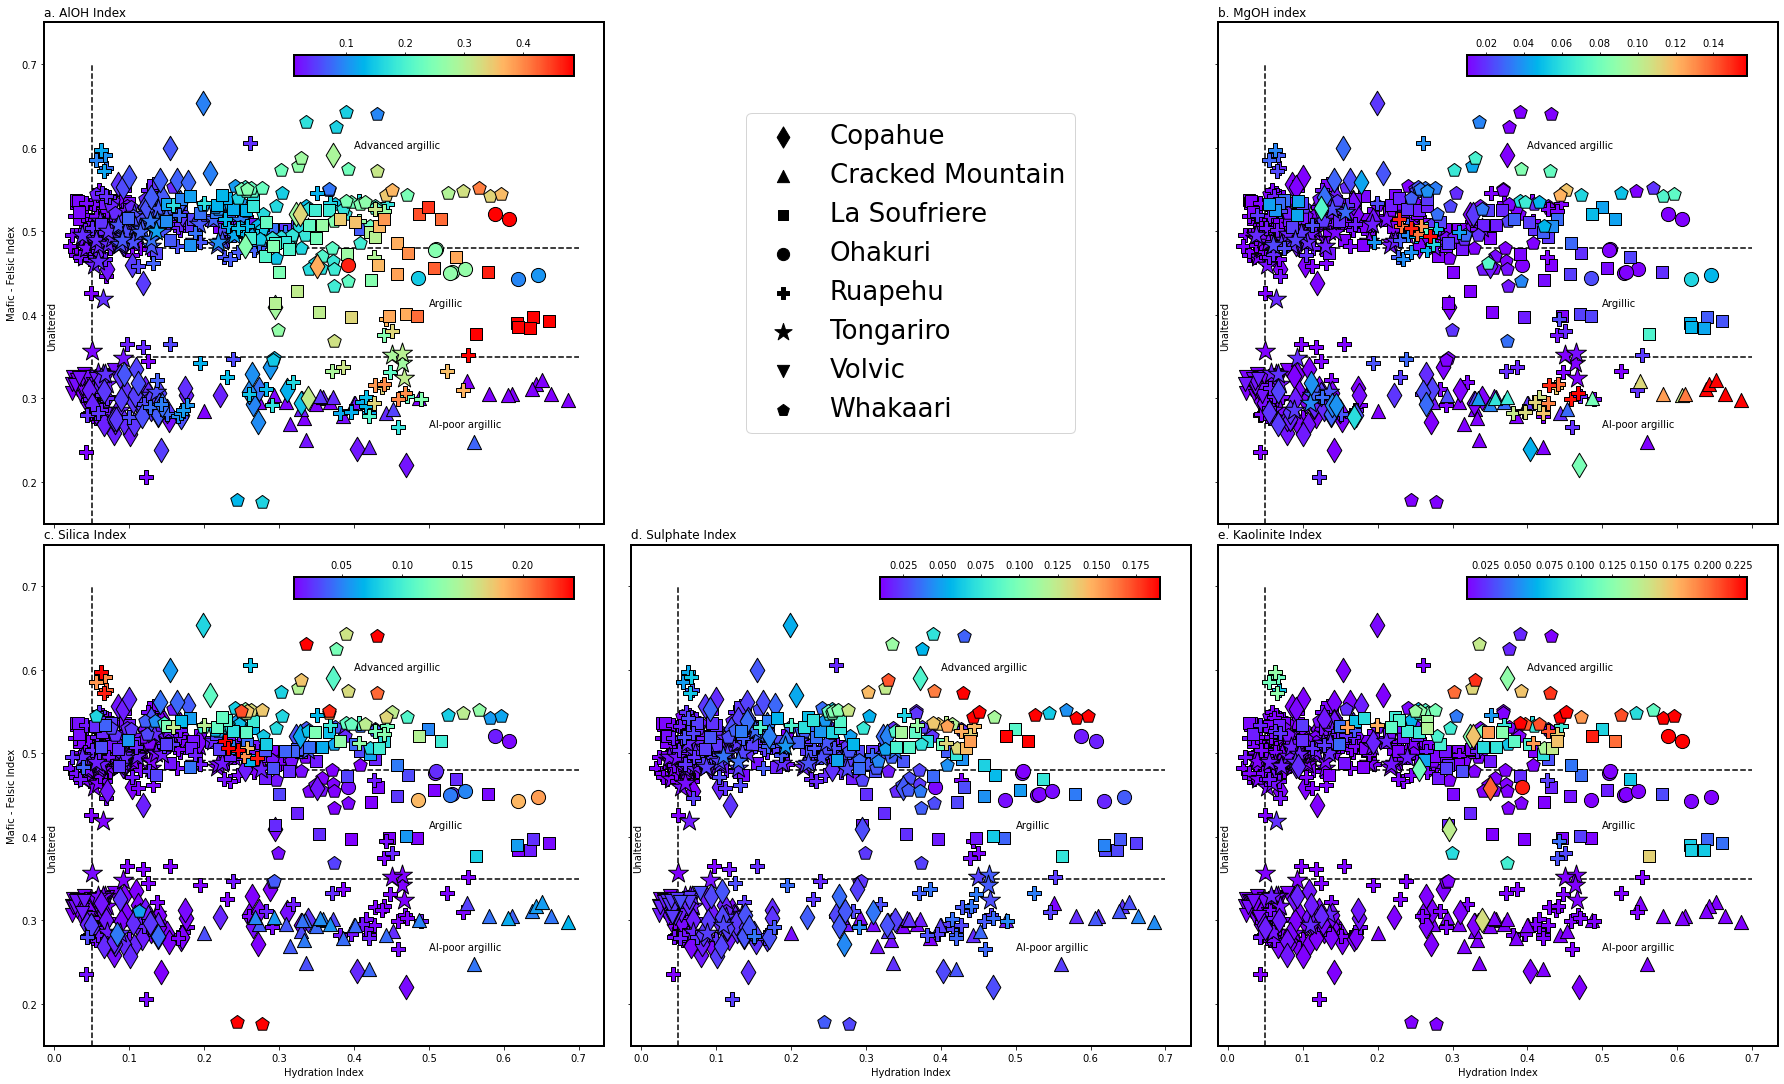

In [8]:
from matplotlib.colorbar import Colorbar
from matplotlib.transforms import Bbox

fig,ax = plt.subplots(2,3,figsize=(25,15), sharex=True, sharey=True)
titles = ['a. AlOH Index', '', 'b. MgOH index',
          'c. Silica Index', 'd. Sulphate Index', 'e. Kaolinite Index' ]
ilist = [indices[k] for k in ['AlOH','FeOH','MgOH','Qtz2','SO4','Kaol']]
ax[1,0].set_xlabel("Hydration Index")
ax[1,1].set_xlabel("Hydration Index")
ax[1,2].set_xlabel("Hydration Index")

ax[0,0].set_ylabel("Mafic - Felsic Index")
ax[1,0].set_ylabel("Mafic - Felsic Index")
fig.tight_layout()

s = {'Copahue':'d','CrackedMountain':'^','LaSoufriere':'s','Ruapehu':'P',
     'Ohakuri':'o','Tongariro':'*','Volvic':'v','Whakaari':'p'}

sz = {'*':2.2,'d':1.5,'p':1.,'+':2, 's':0.8} # adjust default marker size so they are more perceptually uniform
for i,a in enumerate(ax.ravel()):
    _x = indices['hydration']
    _y = indices['fmi']
    c = ilist[i]
    # c = c / np.nanmax(c) # normalise so max is 1
    vmn,vmx = np.nanpercentile( c, (2,99) )
    vmn=0.01 # fix this as the "feature absent" level
    #if i == 3:
    #    vmn = 0.4 # use higher value for quartz index to get better contrast
    if i == 1: # plot legend
        for v in np.unique(volcanoes):
            if v not in s: # skip these as we don't have complete mech data
                continue
            
            # add spaces
            l = v
            if v == 'CrackedMountain' : 
                l = 'Cracked Mountain'
            if v == 'LaSoufriere' : 
                l = 'La Soufriere'
            cm = a.scatter(np.nan, np.nan, s=150*sz.get( s.get(v,'.'), 1),
                    c='k', alpha=1.0, edgecolors='k', marker=s.get(v,'.'), label=l )
        a.legend(loc='center', prop={'size': 26})
        a.set_axis_off()
    else: # plot plots
        # add points individually, so we can customise the z-order (higher values go to front)
        if True:
            for j in range(len(_x)):
                if volcanoes[j] not in s: # skip these as we don't have complete mech data
                    continue
                
                cm = a.scatter([_x[j]], [_y[j]], s=200*sz.get( s[volcanoes[j]], 1), 
                            c=[c[j]], cmap='rainbow', alpha=1.0, edgecolors='k', marker=s.get(volcanoes[j],'.'),
                              vmin=vmn, vmax=vmx, zorder=c[j] )
                #a.text(_x[j], _y[j], sampleIDs[j], fontsize=10, zorder=c[j]+0.1) ## for identifying specific samples
        else: # quicker but not as nice
            for v in np.unique(volcanoes):
                mask = np.array(volcanoes) == v
                ixx = np.argsort(c[mask]) # sort to get better z-order (emphasise high values)
                cm = a.scatter(_x[mask][ixx], _y[mask][ixx], s=200*sz.get( s.get(v,'.'), 1), 
                            c=c[mask][ixx], cmap='rainbow', alpha=1.0, edgecolors='k', marker=s.get(v,'.'),
                              vmin=vmn, vmax=vmx, zorder=np.mean(c[mask]) )

        a.set_title( titles[i], loc='left')
        a.set_ylim(0.15, 0.75)
        
        # Create colorbar in the top-right corner of each axis
        ax_bbox = a.get_position()
        w = 0.5
        cbar_width = w * ax_bbox.width  # Reduce width of the colorbar
        cbar_height = 0.02  # Height of the colorbar
        cbar_x = ax_bbox.x0 + ax_bbox.width * (1-w) - 0.017  # Offset to the top-right
        cbar_y = ax_bbox.y1 - 0.05  # Slightly above the plot
        
        # Create a new axis for the colorbar
        cbar_ax = fig.add_axes([cbar_x, cbar_y, cbar_width, cbar_height])
        cb = Colorbar(cbar_ax, cm, orientation="horizontal")
    
        cb.ax.xaxis.set_ticks_position("top")
        cb.ax.xaxis.set_label_position("top")


        # add labels for alteration regions
        _x = [0.1, 0.7]
        a.plot(_x,[0.35]*2,ls='--', color='k', zorder=0)
        a.plot(_x,[0.48]*2,ls='--', color='k', zorder=0)
        a.plot([0.05]*2,[0.15,0.7],ls='--', color='k', zorder=0)
        a.text( 0.5, 0.265, "Al-poor argillic")
        a.text( 0.5, 0.41, "Argillic")
        a.text( 0.4, 0.6, "Advanced argillic")
        a.text( -0.01, 0.36, "Unaltered", rotation=90)
        

#fig.savefig("./figures/mineralogy.png", dpi=300)
#fig.savefig("./figures/mineralogy.svg", dpi=300)
fig.show()


### Plot mechanical properties

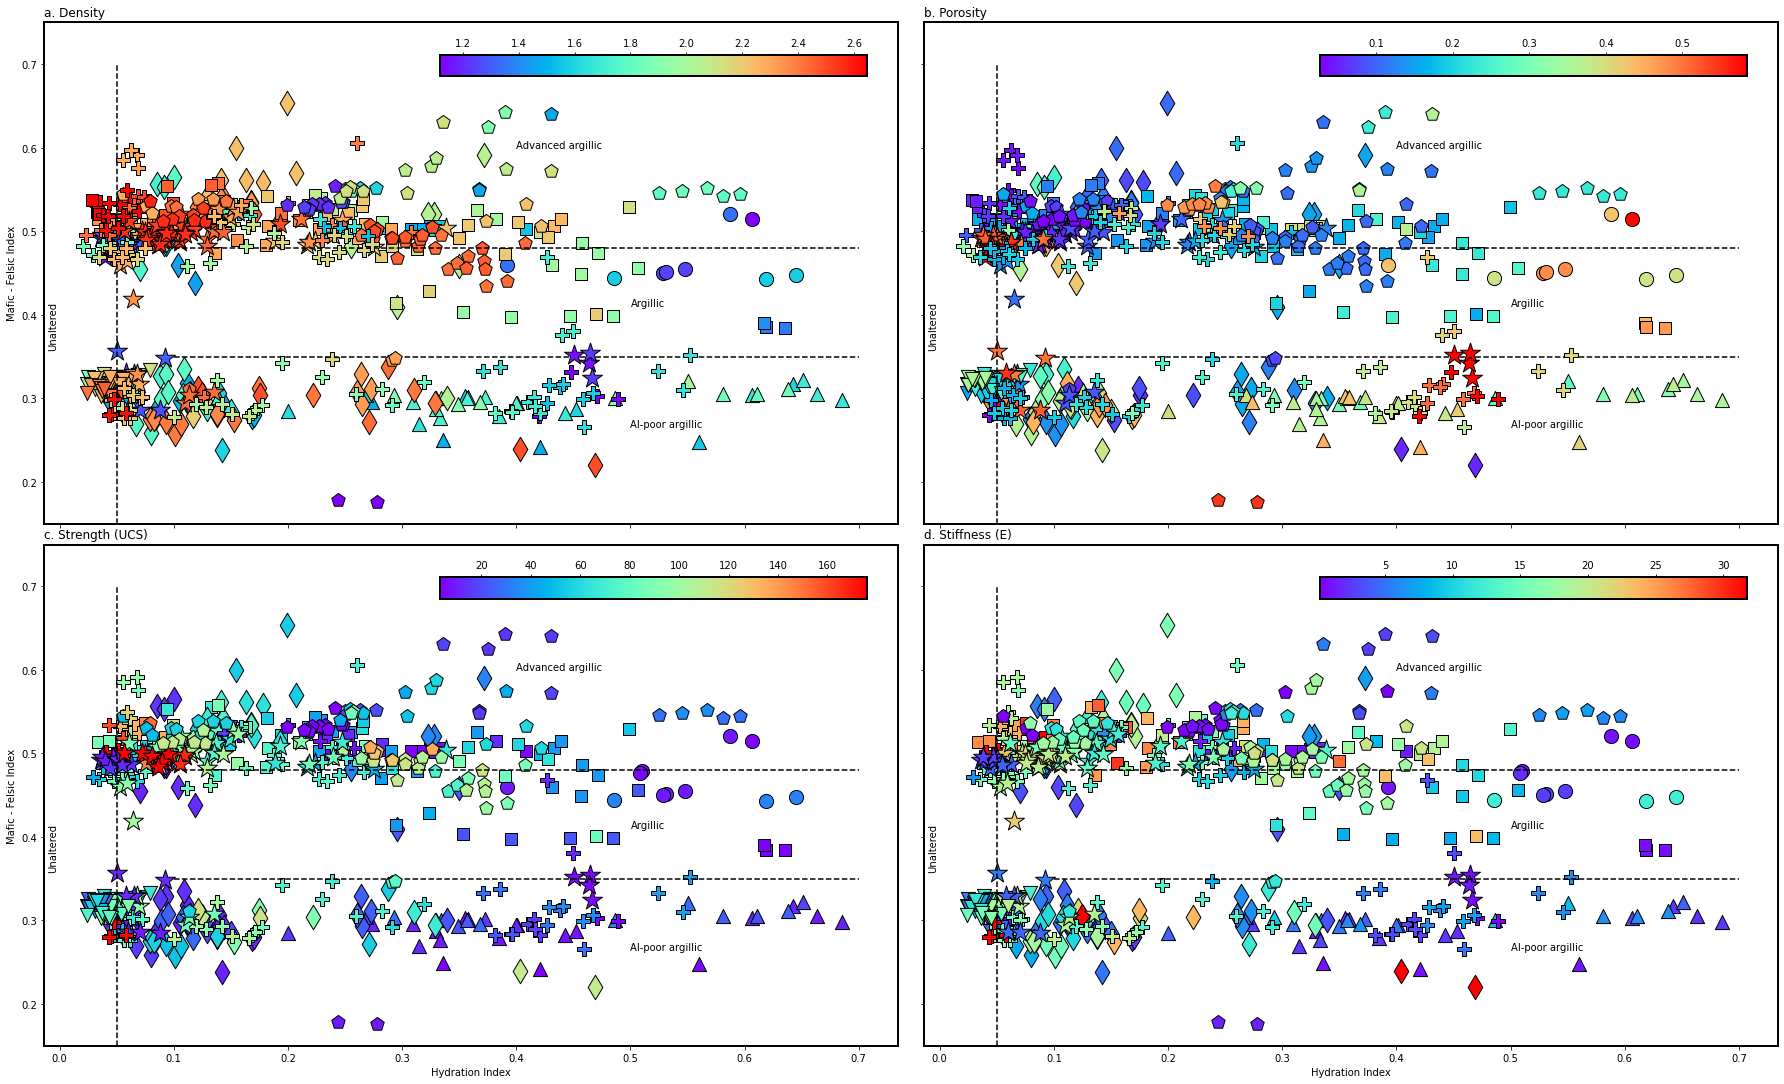

In [9]:
from matplotlib.colorbar import Colorbar
from matplotlib.transforms import Bbox

fig,ax = plt.subplots(2,2,figsize=(25,15), sharex=True, sharey=True)
titles = ['a. Density', 'b. Porosity', 'c. Strength (UCS)', "d. Stiffness (E)"]
ilist = [ np.array([m[i] for m in mech_avg]) for i in range(4)]
ax[1,0].set_xlabel("Hydration Index")
ax[1,1].set_xlabel("Hydration Index")

ax[0,0].set_ylabel("Mafic - Felsic Index")
ax[1,0].set_ylabel("Mafic - Felsic Index")
fig.tight_layout()

s = {'Copahue':'d','CrackedMountain':'^','LaSoufriere':'s','Ruapehu':'P',
     'Ohakuri':'o','Tongariro':'*','Volvic':'v','Whakaari':'p'}
sz = {'*':2.2,'d':1.5,'p':1.,'+':2, 's':0.8} # adjust default marker size so they are more perceptually uniform
for i,a in enumerate(ax.ravel()):
    _x = indices['hydration']
    _y = indices['fmi']
    c = ilist[i]
    # c = c / np.nanmax(c) # normalise so max is 1
    vmn,vmx = np.nanpercentile( c, (2,98) )
    
    # add points individually, so we can customise the z-order (higher values go to front)
    if True:
        for j in range(len(_x)):
            if volcanoes[j] not in s: # skip these as we don't have complete mech data
                continue
            cm = a.scatter([_x[j]], [_y[j]], s=200*sz.get( s.get(volcanoes[j],'.'), 1), 
                        c=[c[j]], cmap='rainbow', alpha=1.0, edgecolors='k', marker=s.get(volcanoes[j],'.'),
                          vmin=vmn, vmax=vmx, zorder=c[j] )
    else: # quicker but not as nice
        for v in np.unique(volcanoes):
            mask = np.array(volcanoes) == v
            ixx = np.argsort(c[mask]) # sort to get better z-order (emphasise high values)
            cm = a.scatter(_x[mask][ixx], _y[mask][ixx], s=200*sz.get( s.get(v,'.'), 1), 
                        c=c[mask][ixx], cmap='rainbow', alpha=1.0, edgecolors='k', marker=s.get(v,'.'),
                          vmin=vmn, vmax=vmx, zorder=np.mean(c[mask]) )
    
    a.set_ylim(0.15, 0.75)
    a.set_title( titles[i], loc='left')

    # Create colorbar in the top-right corner of each axis
    ax_bbox = a.get_position()
    w = 0.5
    cbar_width = w * ax_bbox.width  # Reduce width of the colorbar
    cbar_height = 0.02  # Height of the colorbar
    cbar_x = ax_bbox.x0 + ax_bbox.width * (1-w) - 0.017  # Offset to the top-right
    cbar_y = ax_bbox.y1 - 0.05  # Slightly above the plot
    
    # Create a new axis for the colorbar
    cbar_ax = fig.add_axes([cbar_x, cbar_y, cbar_width, cbar_height])
    cb = Colorbar(cbar_ax, cm, orientation="horizontal")

    cb.ax.xaxis.set_ticks_position("top")
    cb.ax.xaxis.set_label_position("top")


    # add labels for alteration regions
    _x = [0.1, 0.7]
    a.plot(_x,[0.35]*2,ls='--', color='k', zorder=0)
    a.plot(_x,[0.48]*2,ls='--', color='k', zorder=0)
    a.plot([0.05]*2,[0.15,0.7],ls='--', color='k', zorder=0)
    a.text( 0.5, 0.265, "Al-poor argillic")
    a.text( 0.5, 0.41, "Argillic")
    a.text( 0.4, 0.6, "Advanced argillic")
    a.text( -0.01, 0.36, "Unaltered", rotation=90)
    

#fig.savefig("./figures/mechanical.png", dpi=300)
#fig.savefig("./figures/mechanical.svg", dpi=300)
fig.show()



And again, but different.

In [10]:
from scipy.stats import spearmanr

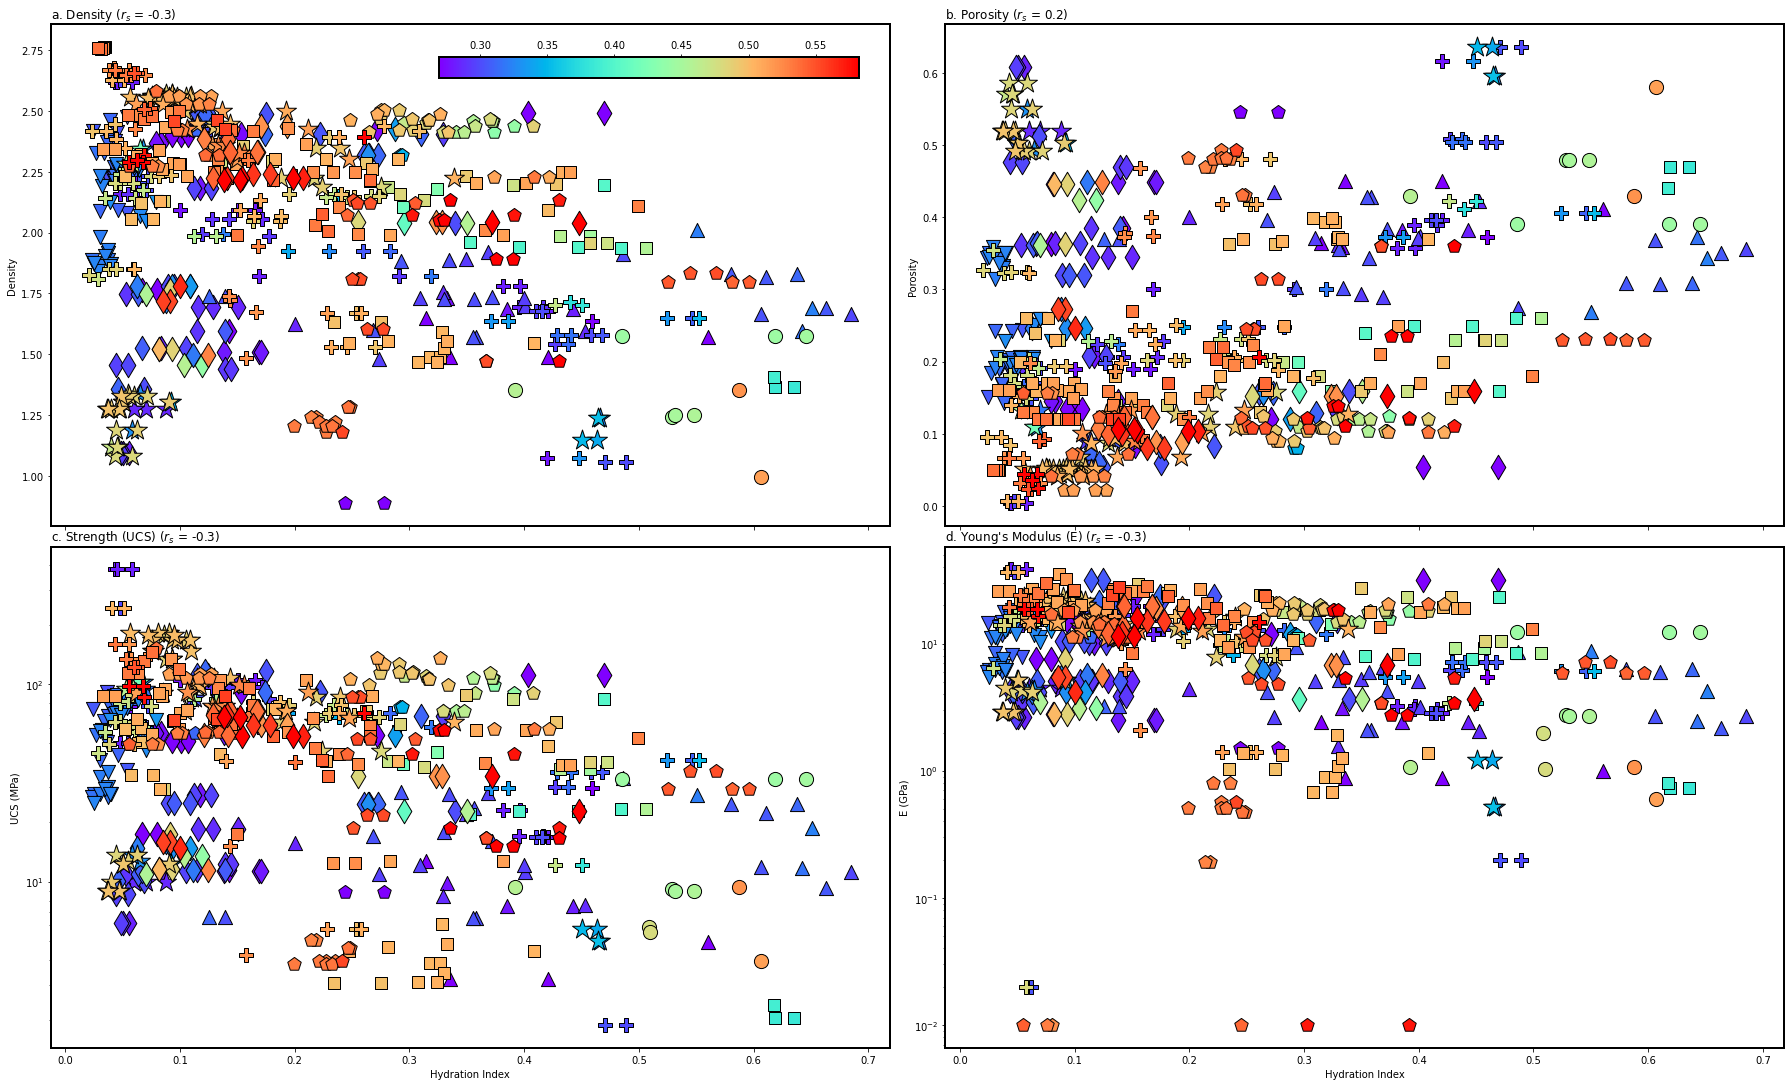

In [11]:
from matplotlib.colorbar import Colorbar
from matplotlib.transforms import Bbox

fig,ax = plt.subplots(2,2,figsize=(25,15), sharex=True, sharey=False)
titles = ['a. Density', 'b. Porosity', 'c. Strength (UCS)', "d. Young's Modulus (E)"]
ilist = [ np.array([m[i] for m in mech_avg]) for i in range(4)]
ax[1,0].set_xlabel("Hydration Index")
ax[1,1].set_xlabel("Hydration Index")

ax[0,0].set_ylabel("Density")
ax[0,1].set_ylabel("Porosity")
ax[1,0].set_ylabel("UCS (MPa)")
ax[1,1].set_ylabel("E (GPa)")

fig.tight_layout()

s = {'Copahue':'d','CrackedMountain':'^','LaSoufriere':'s','Ruapehu':'P',
     'Ohakuri':'o','Tongariro':'*','Volvic':'v','Whakaari':'p'}
sz = {'*':2.2,'d':1.5,'p':1.,'+':2, 's':0.8} # adjust default marker size so they are more perceptually uniform
for i,a in enumerate(ax.ravel()):
    _x = indices['hydration']
    #_y = indices['fmi']
    _y = ilist[i]
    c = indices['fmi']
    #c = ilist[i]
    # c = c / np.nanmax(c) # normalise so max is 1
    vmn,vmx = np.nanpercentile( c, (2,98) )
    
    # add points individually, so we can customise the z-order (higher values go to front)
    for j in range(len(_x)):
        if volcanoes[j] not in s: # skip these as we don't have complete mech data
            continue
        cm = a.scatter([_x[j]], [_y[j]], s=200*sz.get( s.get(volcanoes[j],'.'), 1), 
                    c=[c[j]], cmap='rainbow', alpha=1.0, edgecolors='k', marker=s.get(volcanoes[j],'.'),
                      vmin=vmn, vmax=vmx, zorder=c[j] )
    
    #a.set_ylim(0.15, 0.75)
    mask = np.isfinite(_x) & np.isfinite(_y)
    r, _ = spearmanr( _x[mask], _y[mask] )
    a.set_title( titles[i] + ' ($r_s$ = %.1f)'%r, loc='left')

# Create colorbar in the top-right corner of each axis
a = ax[0,0]
ax_bbox = a.get_position()
w = 0.5
cbar_width = w * ax_bbox.width  # Reduce width of the colorbar
cbar_height = 0.02  # Height of the colorbar
cbar_x = ax_bbox.x0 + ax_bbox.width * (1-w) - 0.017  # Offset to the top-right
cbar_y = ax_bbox.y1 - 0.05  # Slightly above the plot

# Create a new axis for the colorbar
cbar_ax = fig.add_axes([cbar_x, cbar_y, cbar_width, cbar_height])
cb = Colorbar(cbar_ax, cm, orientation="horizontal")

cb.ax.xaxis.set_ticks_position("top")
cb.ax.xaxis.set_label_position("top")

for a in ax[1,:]:
    a.set_yscale('log')
    
#fig.savefig("./figures/mechanical2.png", dpi=300)
#fig.savefig("./figures/mechanical2.svg", dpi=300)
fig.show()
